actor  is running on  cuda:0
critic_1  is running on  cuda:0
critic_2  is running on  cuda:0
target_actor  is running on  cuda:0
target_critic_1  is running on  cuda:0
target_critic_2  is running on  cuda:0
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
episode 0  score -238.20  average score -238.20  n_steps 9
episode 1  score -401.61  average score -319.91  n_steps 45
episode 2  score -132.73  average score -257.51  n_steps 50
episode 3  score -79.43  average score -212.99  n_steps 50
episode 4  score -88.28  average score -188.05  n_steps 50
episode 5  score -204.28  average score -190.75  n_steps 1
episode 6  score -212.63  average score -193.88  n_steps 50
episode 7  score -291.47  average score -206.08  n_steps 19
episode 8  score -224.67  average score -208.14  n_steps 16
episode 9  score -118.08  average score -199.14  n_steps 50
episode 10  score -178.04  average 

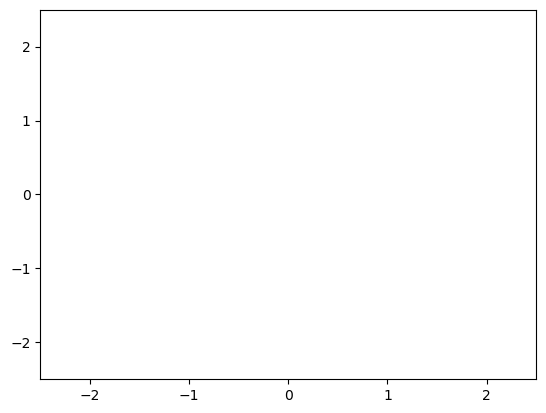

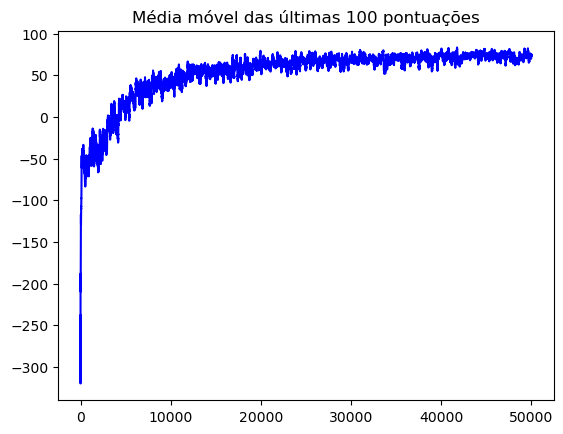

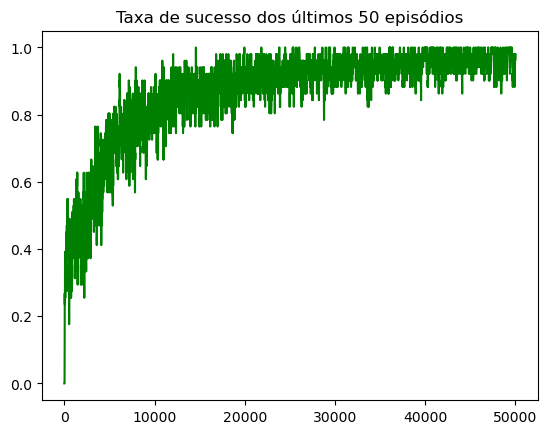

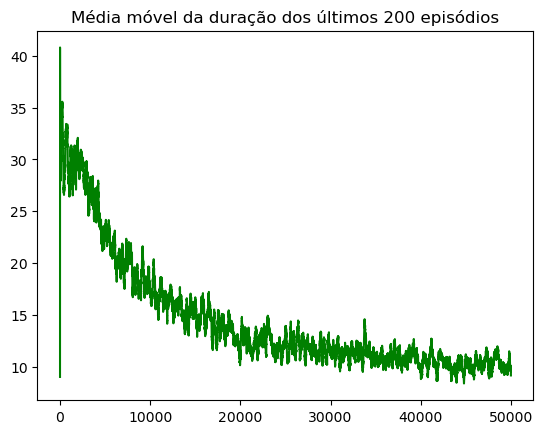

In [5]:
import environment
import numpy as np
from td3_torch import Agent
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg_score = np.zeros(len(scores))
    for i in range(len(running_avg_score)):
        running_avg_score[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg_score, '-b')
    plt.title('Média móvel das últimas 100 pontuações')
    plt.savefig(figure_file)

def plot_success_curve(x, successes, figure_file):
    running_success_rate = np.zeros(len(successes))
    for i in range(len(running_success_rate)):
        running_success_rate[i] = np.mean(successes[max(0, i-50):(i+1)])
    plt.plot(x, running_success_rate, '-g')
    plt.title('Taxa de sucesso dos últimos 50 episódios')
    plt.savefig(figure_file)

def plot_step_curve(x, steps, figure_file):
    running_step_avg = np.zeros(len(steps))
    for i in range(len(running_step_avg)):
        running_step_avg[i] = np.mean(steps[max(0, i-200):(i+1)])
    plt.plot(x, running_step_avg, '-g')
    plt.title('Média móvel da duração dos últimos 200 episódios')
    plt.savefig(figure_file)

if __name__ == '__main__':
    #%matplotlib qt
    plt.ion()
    env = environment.FormiguinhaPBraco5_0()
    agent = Agent(alpha=0.001, beta=0.001, input_dims=env.state_dim, tau=0.005, env_low=env.low, 
                  env_high=env.high, batch_size=100, layer1_size=1600, layer2_size=1000, n_actions=env.action_dim)
    agent.load_models()
    n_games = 50001
    filename = env.name + '_alpha' + str(agent.alpha) + '_beta_' + str(agent.beta) + "_" + str(n_games) + '_games'
    figure_file_score = 'plots/' + filename + '_score.png'
    figure_file_catchrate = 'plots/' + filename + '_catchrate.png'
    figure_file_steps = 'plots/' + filename + '_steps.png'
    animationTH = n_games
    best_score = -9999999
    step_history = []
    score_history = []
    success_history = []
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        success = 0
        plt.axis([-2.5, 2.5, -2.5, 2.5])
        if i>=animationTH:
            plt.scatter(env.targetx, env.targety, marker='x', c='red')
            plt.scatter(env.targetx, env.targety, marker='o', c='red', s=1000, alpha=0.05)
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            score += reward
            observation = observation_
            if reward > 0: success = 1
            if i >= animationTH:
                plt.scatter(env.posx, env.posy, marker='o', c='blue')
                plt.pause(0.01)
        if i >= animationTH:
            plt.pause(0.5)
            plt.clf()
        step_history.append(env.t)
        score_history.append(score)
        success_history.append(success)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score and i>100:
            best_score = avg_score
            agent.save_models()

        print('episode', i, ' score %.2f' %score, ' average score %.2f' %avg_score, ' n_steps %d' %env.t)
    x = [i+1 for i in range(n_games)]
    %matplotlib inline
    plt.figure('learning')
    plot_learning_curve(x, score_history, figure_file_score)
    plt.figure('catching')
    plot_success_curve(x, success_history, figure_file_catchrate)
    plt.figure('steps')
    plot_step_curve(x, step_history, figure_file_steps)